<a href="https://colab.research.google.com/github/samula98/cap_trees/blob/main/6_pt2_USGS_data_trees_w_all_the_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

original data:

https://pubs.usgs.gov/publication/ofr20161106

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import datasets
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import xgboost as xgb
from xgboost import plot_tree, XGBClassifier

import graphviz
from IPython.display import display
from sklearn import tree

import os
import requests

import zipfile
from io import BytesIO
from io import StringIO

## reading in and exploring the data

In [2]:
my_path = pd.ExcelFile('/content/drive/MyDrive/USGS_Logistic_Regression_DS.xlsx')

In [3]:
df_original = pd.read_excel(my_path, 'Appendix1_ModelData')

In [4]:
df_original.head()

,Fire Name,Year,Fire_ID,Fire_SegID,Database,State,UTM_Zone,UTM_X,UTM_Y,Response,...,Peak_I15_mm/h,Peak_I30_mm/h,Peak_I60_mm/h,ContributingArea_km2,PropHM23,dNBR/1000,KF,Acc015_mm,Acc030_mm,Acc060_mm
0,Buckweed,2007,bck,bck_1035,Training,CA,11,368133.5165,3823231.989,0,...,3.2,2.0,2.0,0.378767,0.217933,0.297853,0.250000,0.8,1.0,2.0
1,Buckweed,2007,bck,bck_1090,Training,CA,11,367871.0165,3822984.489,0,...,3.2,2.0,2.0,0.689615,0.061249,0.224896,0.250000,0.8,1.0,2.0
2,Buckweed,2007,bck,bck_1570,Training,CA,11,367503.5165,3821741.989,0,...,3.2,2.0,2.0,2.757312,0.042968,0.065537,0.248541,0.8,1.0,2.0
3,Buckweed,2007,bck,bck_235,Training,CA,11,371108.5165,3824991.989,0,...,1.6,1.2,0.8,0.613415,0.092164,0.141711,0.250000,0.4,0.6,0.8
4,Buckweed,2007,bck,bck_363,Training,CA,11,370763.5165,3824576.989,0,...,1.6,1.2,0.8,0.538875,0.058353,0.210158,0.250000,0.4,0.6,0.8


In [5]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Fire Name             1550 non-null   object        
 1   Year                  1550 non-null   int64         
 2   Fire_ID               1550 non-null   object        
 3   Fire_SegID            1550 non-null   object        
 4   Database              1550 non-null   object        
 5   State                 1550 non-null   object        
 6   UTM_Zone              1550 non-null   int64         
 7   UTM_X                 1550 non-null   float64       
 8   UTM_Y                 1550 non-null   float64       
 9   Response              1550 non-null   int64         
 10  StormDate             1550 non-null   object        
 11  GaugeDist_m           1550 non-null   float64       
 12  StormStart            1390 non-null   datetime64[ns]
 13  StormEnd          

In [6]:
df_original.shape

(1550, 27)

In [7]:
df_original.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
Year,1550.0,2006.933548,2000.0,2003.0,2009.0,2009.0,2012.0,3.466538
UTM_Zone,1550.0,11.616129,11.0,11.0,11.0,12.0,13.0,0.836003
UTM_X,1550.0,403991.974249,235282.7837,369957.9273,392059.0183,444386.2944,733557.4531,88105.486725
UTM_Y,1550.0,3926657.821777,3468148.423,3787833.9125,3795699.121,3908735.072,5110115.734,306377.242095
Response,1550.0,0.215484,0.0,0.0,0.0,0.0,1.0,0.41129
GaugeDist_m,1550.0,1958.996196,27.843965,1037.46,1913.675,2811.0275,3999.3,1071.810282
StormStart,1390,2008-01-15 18:59:50.762589952,2000-07-16 12:09:00,2003-12-24 23:19:00,2009-12-10 21:14:00,2010-01-21 04:06:00,2013-08-09 15:30:00,NaN
StormEnd,1390,2008-01-16 15:30:14.071942400,2000-07-16 13:06:00,2003-12-25 23:55:15,2009-12-11 07:10:00,2010-01-22 17:24:00,2013-08-09 20:25:00,NaN
StormDur_H,1550.0,18.446009,0.0,2.0,14.3,27.1375,65.0,18.507975
StormAccum_mm,1550.0,34.971515,0.0,8.38,22.0,51.2,222.25,38.37491


In [8]:
df_original.isnull().sum()

,0
Fire Name,0
Year,0
Fire_ID,0
Fire_SegID,0
Database,0
State,0
UTM_Zone,0
UTM_X,0
UTM_Y,0
Response,0


In [9]:
df_original.isnull().sum().sum()

1797

In [10]:
df = df_original.copy()

In [11]:
df.nunique()

,0
Fire Name,34
Year,12
Fire_ID,34
Fire_SegID,716
Database,2
State,7
UTM_Zone,3
UTM_X,707
UTM_Y,708
Response,2


In [12]:
# for this notebook we are keeping all the 15,30,60 values for Peak and Acc
list_to_drop = ['Fire Name', 'Fire_ID', 'Database', 'Fire_SegID', 'State',
                'StormStart', 'StormEnd', 'StormDate', 'UTM_X', 'UTM_Y',
                # 'Peak_I15_mm/h',
                # 'Peak_I30_mm/h',
                # 'Peak_I60_mm/h',
                # 'Acc015_mm',
                # 'Acc030_mm',
                # 'Acc060_mm',
                ]

In [13]:
type(list_to_drop)

list

In [14]:
df.drop(list_to_drop, axis = 1, inplace = True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  1550 non-null   int64  
 1   UTM_Zone              1550 non-null   int64  
 2   Response              1550 non-null   int64  
 3   GaugeDist_m           1550 non-null   float64
 4   StormDur_H            1550 non-null   float64
 5   StormAccum_mm         1550 non-null   float64
 6   StormAvgI_mm/h        1550 non-null   float64
 7   Peak_I15_mm/h         1320 non-null   float64
 8   Peak_I30_mm/h         1336 non-null   float64
 9   Peak_I60_mm/h         1294 non-null   float64
 10  ContributingArea_km2  1550 non-null   float64
 11  PropHM23              1550 non-null   float64
 12  dNBR/1000             1473 non-null   float64
 13  KF                    1550 non-null   float64
 14  Acc015_mm             1320 non-null   float64
 15  Acc030_mm            

In [16]:
def fill_nulls_with_mean(df):
  """
  Replaces null values in a DataFrame with the mean of each column.

  Args:
    df: The pandas DataFrame to process.

  Returns:
    A DataFrame with null values replaced by column means.
  """

  for column in df.columns:
    column_mean = df[column].mean()
    df[column].fillna(column_mean, inplace=True)

  return df

In [17]:
df_no_nulls = fill_nulls_with_mean(df)

<ipython-input-16-22b674667130>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(column_mean, inplace=True)


In [18]:
df.isnull().sum()

,0
Year,0
UTM_Zone,0
Response,0
GaugeDist_m,0
StormDur_H,0
StormAccum_mm,0
StormAvgI_mm/h,0
Peak_I15_mm/h,0
Peak_I30_mm/h,0
Peak_I60_mm/h,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1550 entries, 0 to 1549
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  1550 non-null   int64  
 1   UTM_Zone              1550 non-null   int64  
 2   Response              1550 non-null   int64  
 3   GaugeDist_m           1550 non-null   float64
 4   StormDur_H            1550 non-null   float64
 5   StormAccum_mm         1550 non-null   float64
 6   StormAvgI_mm/h        1550 non-null   float64
 7   Peak_I15_mm/h         1550 non-null   float64
 8   Peak_I30_mm/h         1550 non-null   float64
 9   Peak_I60_mm/h         1550 non-null   float64
 10  ContributingArea_km2  1550 non-null   float64
 11  PropHM23              1550 non-null   float64
 12  dNBR/1000             1550 non-null   float64
 13  KF                    1550 non-null   float64
 14  Acc015_mm             1550 non-null   float64
 15  Acc030_mm            

In [20]:
df['Response'].value_counts()

,count
Response,
0,1216
1,334


<Axes: >

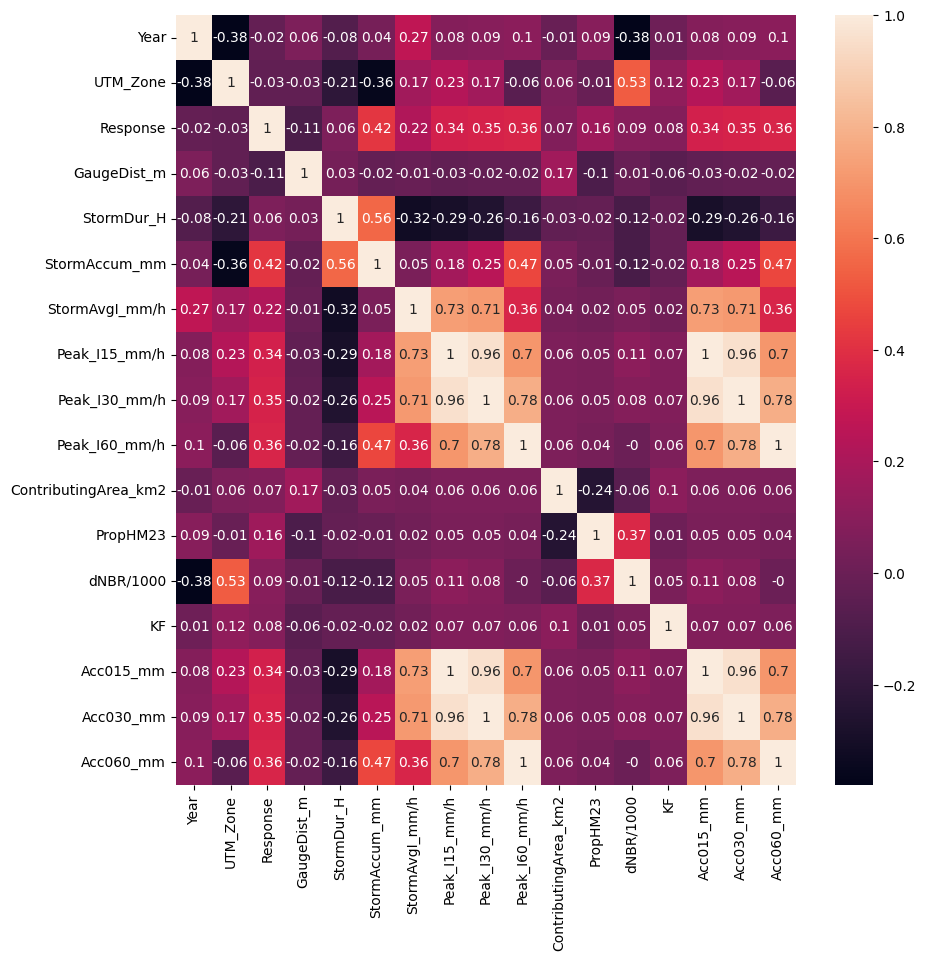

In [21]:
plt.figure(figsize = (10,10))
correlation_matrix = df.corr().round(2)
sns.heatmap(data = correlation_matrix, annot = True)

## decision tree

In [22]:
X = df.drop('Response', axis = 1)
y = df['Response']

**accuracy** = (TP + TN) / (TP + FP +TN + TP)

{good for when classes are balanced and not skewed}

**precision** = TP / (TP + FP)

{when we want to be very sure in our POSITIVE predictions}

**recall** = TP / (TP + FN)

{want to classify as many POSITIVES as possible}

**F1** = 2[(precision * recall)/(precision + recall)]

{when you want HIGH PRECISION & HIGH RECALL}

In [28]:
numLoops = 20
acc = np.zeros(numLoops)
for idx in range(0, numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  model = DecisionTreeRegressor(max_depth = 3)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  acc[idx] = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'accuracy?: {acc.mean().round(2)}')

accuracy?: 0.34


In [23]:
# choosing tree depth
max_depths = [1,2,3,4,5,6,7,8,9,10]
# acc = np.zeros(len(max_depths))
# std_depth = np.zeros(len(max_depths))
numLoops = 20
for n, depth in enumerate(max_depths):
  # rms_error = np.zeros(numLoops)
  for idx in range(0, numLoops):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    model = DecisionTreeRegressor(max_depth = depth)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc[idx] = np.
    # rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))

In [24]:
pd.DataFrame(zip(max_depths))

,0
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


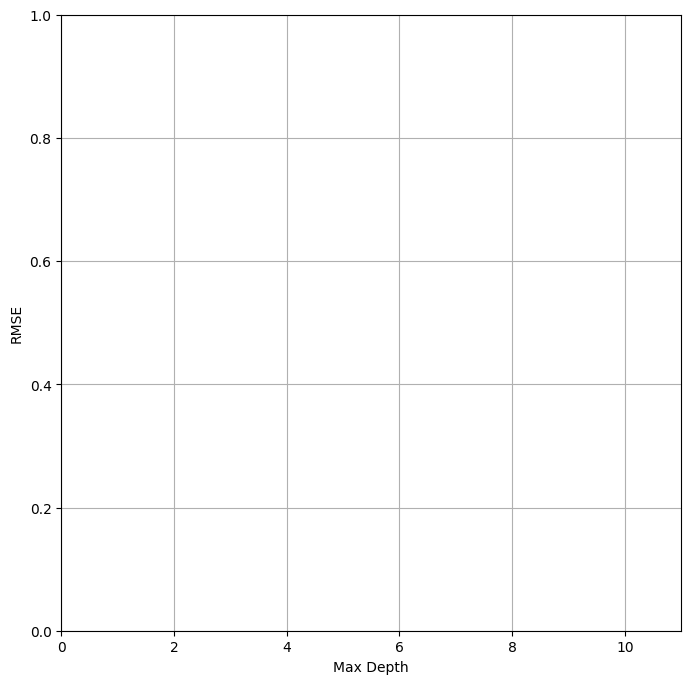

In [25]:
plt.figure(figsize = (8,8))
# plt.plot(max_depths) # accuracy or f1
plt.xlabel('Max Depth')
plt.ylabel('RMSE')
plt.xlim(0,11)
plt.grid()

In [ ]:
# re-run with max depth = 4
numLoops = 20

# rms_error = np.zeros(numLoops)
for idx in range(0, numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  model = DecisionTreeRegressor(max_depth = 4)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  # rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))
# print(f'CV RMSE: {rms_error.mean().round(2)}')

In [ ]:
# re-run with max depth = 5
numLoops = 20

rms_error = np.zeros(numLoops)
for idx in range(0, numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  model = DecisionTreeRegressor(max_depth = 5)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'CV RMSE: {rms_error.mean().round(2)}')

In [ ]:
# re-run with max depth = 6
numLoops = 20

rms_error = np.zeros(numLoops)
for idx in range(0, numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  model = DecisionTreeRegressor(max_depth = 6)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'CV RMSE: {rms_error.mean().round(2)}')

In [ ]:
## as we can see herre, the max depth stays aound 0.35 - 0.37 between the input values of 4 to 6, so I'll stick with 5?

In [ ]:
display(
  graphviz.Source(
    tree.export_graphviz(
      model,
      feature_names = X.columns,
      filled = True,
    )
  )
)

In [ ]:
# skinny tree
plt.figure(figsize = (30,15))
# plot is as a .svg -- at the end
tree_plot = tree.plot_tree(
    model,
    feature_names = X.columns,
    filled = True,
    fontsize = 5,
)

## random forest

In [ ]:
X = usgs_cor_df.drop('Response', axis = 1)
y = usgs_cor_df['Response']

In [ ]:
numLoops = 20
mean_error = np.zeros(numLoops)
for idx in range(0, numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  model = DecisionTreeRegressor(max_depth = 3, random_state = 0)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')

In [ ]:
numLoops = 20
mean_error = np.zeros(numLoops)
for idx in range(0, numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  model = RandomForestRegressor(n_estimators = 4)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  mean_error[idx] = mean_squared_error(y_test, y_pred)
print(f'RMSE: {np.sqrt(mean_error).mean()}')
print(f'RMSE_std: {np.sqrt(mean_error).std()}')
np.sqrt(mean_error)[:10] # shows an array of the first 10 std rmse values

In [ ]:
# choosing number of trees
num_trees = range(10,60,10)
cv_loops = 20
rmse_results = np.zeros(len(num_trees))
std_results = np.zeros(len(num_trees))
for n, trees in enumerate(num_trees):
  rmse_cv = np.zeros(cv_loops)
  np.random.seed(13)
  for i in range(cv_loops):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    rfModel = RandomForestRegressor(n_estimators = trees)
    rfModel.fit(X_train, y_train)
    y_pred_rf = rfModel.predict(X_test)
    rmse_cv[i] = np.sqrt(mean_squared_error(y_test, y_pred_rf))
  print(trees, 'trees finished')
  rmse_results[n] = rmse_cv.mean()
  std_results[n] = rmse_cv.std()

In [ ]:
pickle.dump(rfModel, open('rfModel.p', 'wb'))

In [ ]:
plt.plot(num_trees, rmse_results)
plt.xlabel('Tree Number')
plt.ylabel('RMSE')
plt.title('Random Forest')
plt.grid()

In [ ]:
pd.DataFrame(zip(rmse_results, std_results,))

In [ ]:
plt.errorbar(num_trees, rmse_results, yerr = std_results)
plt.xlabel('Tree Number')
plt.ylabel('RMSE')
plt.xlim(0,60)
plt.ylim(0,0.4)
plt.grid()

In [ ]:
print(f'RMSE with 40 trees: {rmse_results[3]}')

In [ ]:
len(rfModel.estimators_)

In [ ]:
display(
  graphviz.Source(
    tree.export_graphviz(
      rfModel.estimators_[0],
      feature_names = X.columns,
      filled = True,
    )
  )
)

In [ ]:
# importance predictors
importances = rfModel.feature_importances_
forest_importances = pd.Series(importances, index = X.columns)
plt.figure()
forest_importances.sort_values(ascending = False).plot.bar()
plt.title('Feature Importances')
plt.ylabel('Feature Importance Score')
plt.xlabel('Feature')

In [ ]:
(forest_importances.sort_values(ascending = False) * 100).cumsum()

## XG Boost

In [ ]:
X = usgs_cor_df.drop('Response', axis = 1)
y = usgs_cor_df['Response']

In [ ]:
numLoops = 20
mse_xgb = np.zeros(numLoops)
for idx in range(0, numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  xgbr = xgb.XGBRegressor(objective = 'reg:squarederror', verbosity = 0, seed = 13)
  xgbr.fit(X_train, y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test, y_pred_xgb)
print(f'RMSE: {np.sqrt(mse_xgb).mean()}')

In [ ]:
y_pred_xgb[0]

In [ ]:
y_test.to_numpy()[0]

In [ ]:
# specifying parameters we want to try and their ranges
param_test = {
    'max_depth' : [3, 4, 5, 6, 7],
    'learning_rate' : [0.1, 0.2, 0.3, 0.4],
    'n_estimators' : [20, 40, 60, 80, 100, 120, 140],
}
# grid search
gsearch = GridSearchCV(
    estimator = xgb.XGBRegressor(objective = 'reg:squarederror', seed = 10),
    param_grid = param_test,
    scoring = 'neg_mean_squared_error',
    cv = 5,
)
# fit to the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 13)
model = gsearch.fit(X_train, y_train)
# show results
print(model.best_params_)

In [ ]:
# re-testing parameters to see if we have a good fit for the model (in this case just trying different max_depth values)
# specifying parameters we want to try and their ranges
param_test = {
    'max_depth' : [1, 2, 3, 4, 5, 6],
    'learning_rate' : [0.1, 0.2, 0.3, 0.4],
    'n_estimators' : [20, 40, 60, 80, 100, 120, 140],
}
# grid search
gsearch = GridSearchCV(
    estimator = xgb.XGBRegressor(objective = 'reg:squarederror', seed = 10),
    param_grid = param_test,
    scoring = 'neg_mean_squared_error',
    cv = 5,
)
# fit to the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 13)
model = gsearch.fit(X_train, y_train)
# show results
print(model.best_params_)

In [ ]:
# fitting XGBoost model with the best parameters
numLoops = 20
mse_xgb = np.zeros(numLoops)
for idx in range(0, numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
  xgbr = xgb.XGBRegressor(
      objective = 'reg:squarederror',
      verbosity = 0,
      learning_rate = 0.3,
      max_depth = 3,
      n_estimators = 60,
      seed = 10,
  )
  xgbr.fit(X_train, y_train)
  y_pred_xgb = xgbr.predict(X_test)
  mse_xgb[idx] = mean_squared_error(y_test, y_pred_xgb)
print(f'RMSE: {np.sqrt(mse_xgb).mean()}')

In [ ]:
# plot
# plt.figure(figsize = (30,20))
plot_tree(xgbr)#, num_trees = 7)
# plt.show()


In [ ]:
plot_tree(xgbr); plt.show()

In [ ]:
plot_tree(xgbr, num_trees = 10); plt.show()

In [ ]:
plot_tree(xgbr, num_trees = 0, rankdir = 'LR'); plt.show()

In [ ]:
# feature importance
feat_import = pd.Series(xgbr.feature_importances_, index = X.columns)
plt.figure(figsize = (8,8))
ax = sns.barplot(x = feat_import.index, y = feat_import.sort_values(ascending = False).values)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.xlabel('Feature')
plt.title('XGBoost')
plt.ylabel('Feature Importance Score');

In [ ]:
(feat_import.sort_values(ascending = False) * 100).cumsum()